In [1]:
import sys

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from bindsnet.environment import GymEnvironment
from bindsnet.pipeline import EnvironmentPipeline
from bindsnet.learning.reward import AbstractReward, MovingAvgRPE
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_weights
from agents import AcrobotAgent

In [3]:
def _compute_spikes(
    datum: torch.Tensor,
    time: int,
    low: float,
    high: float,
    device: str
) -> torch.Tensor:
    times = torch.linspace(low, high, time, device=device)
    spike_times = torch.argmin(torch.abs(datum - times))
    spikes = (np.array(spike_times.to('cpu')).astype(int) ==
              range(0, time)).astype(int)
    reverse_spikes = np.flip(spikes).copy()
    return torch.stack([
        torch.from_numpy(spikes).to(device),
        torch.from_numpy(reverse_spikes).to(device)
    ]).byte()

In [4]:
def acrobot_observation_encoder(
        datum: torch.Tensor,
        time: int,
        **kwargs,
) -> dict:
    """

    Parameters
    ----------
    datum : torch.Tensor
        Observation tensor.
    time : int
        Length of spike train per observation.

    Keyword Arguments
    -----------------

    Returns
    -------
    dict
        The tensor of encoded data per input population.

    """
    device = "cpu" if datum.get_device() < 0 else 'cuda'
    datum = datum.squeeze()
    if (len(datum)==6):
        cos1, sin1, cos2, sin2, vel1, vel2 = datum
    else:
        theta1, theta2, vel1, vel2 = datum
        cos1 = np.cos(theta1)
        sin1 = np.sin(theta1)
        cos2 = np.cos(theta2)
        sin2 = np.sin(theta2)
    
    min_cos1, max_cos1 = -1.0, 1.0
    min_sin1, max_sin1 = -1.0, 1.0
    min_cos2, max_cos2 = -1.0, 1.0
    min_sin2, max_sin2 = -1.0, 1.0
    min_vel1, max_vel1 = -12.57, 12.57
    min_vel2, max_vel2 = -28.27, 28.27

    cos1_spikes = _compute_spikes(cos1, time, min_cos1, max_cos1, device)
    sin1_spikes = _compute_spikes(sin1, time, min_sin1, max_sin1, device)
    cos2_spikes = _compute_spikes(cos2, time, min_cos2, max_cos2, device)
    sin2_spikes = _compute_spikes(sin2, time, min_sin2, max_sin2, device)
    vel1_spikes = _compute_spikes(vel1, time, min_vel1, max_vel1, device)
    vel2_spikes = _compute_spikes(vel2, time, min_vel2, max_vel2, device)

    spikes = torch.stack([cos1_spikes, sin1_spikes, cos2_spikes, sin2_spikes, vel1_spikes, vel2_spikes]).T

    return {"S2": spikes.unsqueeze(1).byte().to(device)}

In [5]:
def select_action(pipeline, output, **kwargs) -> int:
    """
    Choose the proper action based on observation.

    Keyword Arguments
    -----------------

    Returns
    -------
    action : int
        The action to be taken.

    """
    if pipeline.network.monitors[output].recording['s'] != []:
        spikes = (pipeline.network.monitors[output].get("s").float())
        spikes = spikes.squeeze().squeeze().nonzero()
        
#         print("spikes: ", spikes)
#         print("spikes: ", spikes.shape)

        if spikes.shape[0] == 0:
            return pipeline.env.action_space.sample()
        else:
            return spikes[0, 1]
    return pipeline.env.action_space.sample()

In [6]:
# Define the environment
environment = GymEnvironment('Acrobot-v1', render_mode='human')

In [7]:
# Define observer agent
observer = AcrobotAgent(environment, dt=1.0, method='first_spike')

In [8]:
observer.build_network()

In [9]:
pipeline = EnvironmentPipeline(
    network=observer.network,
    environment=environment,
    action_function=select_action,
    encoding=acrobot_observation_encoder,
    device=observer.device,
    output="PM",
    time=25,
    num_episodes=100,
)

In [10]:
w1 = pipeline.network.connections[("S2", "PM")].w
# plot_weights(w1)
print(w1)

Parameter containing:
tensor([[0.5023, 0.4947, 0.4933],
        [0.5095, 0.4982, 0.4907],
        [0.5016, 0.4956, 0.4828],
        [0.4878, 0.4985, 0.4877],
        [0.4907, 0.4761, 0.5004],
        [0.5024, 0.4913, 0.5075],
        [0.5055, 0.5023, 0.5106],
        [0.5014, 0.5099, 0.5012],
        [0.5088, 0.4964, 0.4979],
        [0.5057, 0.4922, 0.4975],
        [0.4944, 0.4949, 0.4972],
        [0.4889, 0.4985, 0.4981]])


In [11]:
pipeline.train()
print("Training Finished")

Episode: 0 - accumulated reward: -250.00
Episode: 1 - accumulated reward: -250.00
Episode: 2 - accumulated reward: -250.00
Episode: 3 - accumulated reward: -250.00
Episode: 4 - accumulated reward: -250.00
Episode: 5 - accumulated reward: -250.00
Episode: 6 - accumulated reward: -225.00
Episode: 7 - accumulated reward: -250.00
Episode: 8 - accumulated reward: -250.00
Episode: 9 - accumulated reward: -250.00
Episode: 10 - accumulated reward: -250.00
Episode: 11 - accumulated reward: -113.00
Episode: 12 - accumulated reward: -250.00
Episode: 13 - accumulated reward: -250.00
Episode: 14 - accumulated reward: -99.00
Episode: 15 - accumulated reward: -250.00
Episode: 16 - accumulated reward: -250.00
Episode: 17 - accumulated reward: -250.00
Episode: 18 - accumulated reward: -250.00
Episode: 19 - accumulated reward: -250.00
Episode: 20 - accumulated reward: -250.00
Episode: 21 - accumulated reward: -250.00
Episode: 22 - accumulated reward: -250.00
Episode: 23 - accumulated reward: -250.00
Epi

Text(0.5, 0, 'episode')

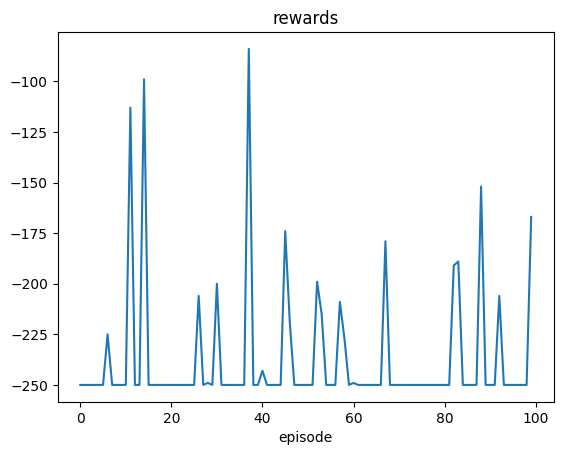

In [12]:
plt.plot(pipeline.reward_list)
plt.title('rewards')
plt.xlabel('episode')

In [13]:
np.mean(pipeline.reward_list)

-237.45

In [14]:
w1 = pipeline.network.connections[("S2", "PM")].w
# plot_weights(w1)
print(w1)

Parameter containing:
tensor([[ 0.2538,  0.2609,  0.2412],
        [ 0.1891,  0.2355,  0.2303],
        [ 0.3110,  0.3033,  0.2987],
        [ 0.2241,  0.1984,  0.2136],
        [-0.0392, -0.0325, -0.0200],
        [-0.0369, -0.0269, -0.0073],
        [ 0.2287,  0.2147,  0.2167],
        [ 0.1263,  0.0794,  0.0780],
        [ 0.2918,  0.2610,  0.2731],
        [ 0.3768,  0.3544,  0.3450],
        [-0.0205,  0.0067, -0.0177],
        [-0.0453, -0.0108, -0.0222]])
